<a href="https://www.kaggle.com/code/a7madmostafa/clothes-classification?scriptVersionId=200021516" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **The Notebook is under Editing**

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import load_img

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE = 224

# Load Dataset

In [3]:
len(os.listdir('/kaggle/input/clothing-dataset-full/images_compressed'))

5762

In [4]:
len(os.listdir('/kaggle/input/clothing-dataset-full/images_original'))

5762

In [5]:
labels = pd.read_csv('/kaggle/input/clothing-dataset-full/images.csv')
labels.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


In [6]:
labels.shape

(5403, 4)

In [7]:
labels.label.value_counts()

label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: count, dtype: int64

In [8]:
# Remove images with 'Skip' as  they are corrupted
labels = labels[labels['label'] != 'Skip']

# Add '.jpg' extension
labels['image'] = labels['image'] + '.jpg'

In [9]:
labels.shape

(5391, 4)

In [10]:
labels_lst = labels.label.unique().tolist()
labels_lst

['Not sure',
 'T-Shirt',
 'Shoes',
 'Shorts',
 'Shirt',
 'Pants',
 'Skirt',
 'Other',
 'Top',
 'Outwear',
 'Dress',
 'Body',
 'Longsleeve',
 'Undershirt',
 'Hat',
 'Polo',
 'Blouse',
 'Hoodie',
 'Blazer']

In [11]:
labels.label.value_counts()

label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Not sure       228
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Name: count, dtype: int64

# Splitting the dataset

In [12]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(labels, test_size=0.1, random_state=42, stratify=labels['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

In [13]:
try:
    parent_dir = '/kaggle/working/clothes'
    os.mkdir(parent_dir)

    for split in ['training', 'validation', 'testing']:
        path = os.path.join(parent_dir , split)
        os.mkdir(path)
        for label  in labels_lst:
            n_path = os.path.join(path , label)
            os.mkdir(n_path)
except OSError:
    print('Existing Directories')

In [14]:
not_found_images = []

def copy_files(file_df, split, source_dir, destination_dir):
    global not_found_images
    for _, row in file_df.iterrows():
        img_name = row['image']
        label = row['label']
        
        # Define source and destination paths
        src = os.path.join(source_dir, img_name)
        dst = os.path.join(destination_dir, split, label, img_name)
        
        try:
            # Copy the file
            shutil.copy2(src, dst)
        except FileNotFoundError:
            not_found_images.append(src)

In [15]:
source_dir = '/kaggle/input/clothing-dataset-full/images_compressed'
destination_dir = '/kaggle/working/clothes'

# Copy images to the appropriate directories
copy_files(train_df, 'training', source_dir, destination_dir)
copy_files(val_df, 'validation', source_dir, destination_dir)
copy_files(test_df, 'testing', source_dir, destination_dir)

In [16]:
len(not_found_images) # No images not found

0

# Display Sample images

In [17]:
# Display Sample image

def display_sample_image(split, label):
    images = os.listdir(os.path.join(destination_dir, split, label))
    img = random.choice(images)
    return load_img(os.path.join(destination_dir, split, label, img), target_size=(IMAGE_SIZE, IMAGE_SIZE))

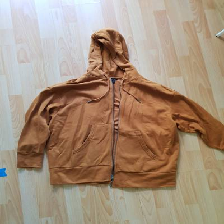

In [18]:
display_sample_image('training', 'Hoodie')

In [19]:
# Display Sample images

def display_sample_images(split, label):
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(display_sample_image(split, label))
        plt.axis('off')
    plt.show()

Not sure


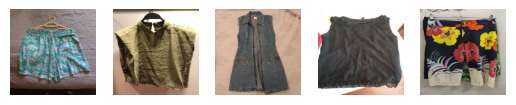

T-Shirt


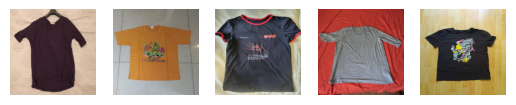

Shoes


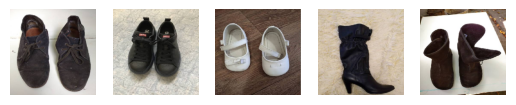

Shorts


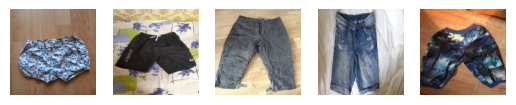

Shirt


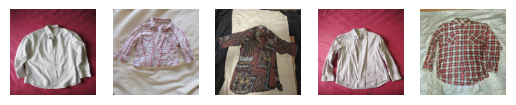

Pants


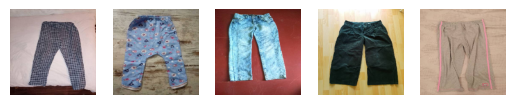

Skirt


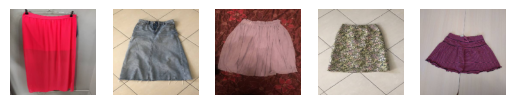

Other


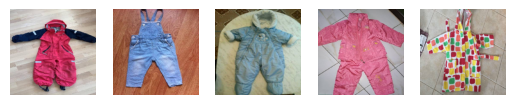

Top


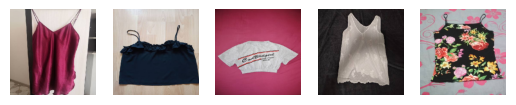

Outwear


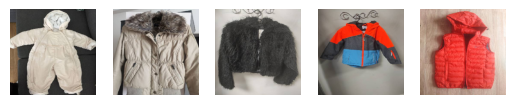

Dress


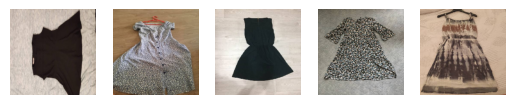

Body


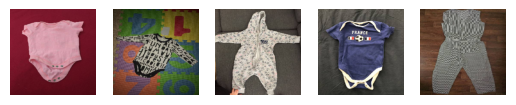

Longsleeve


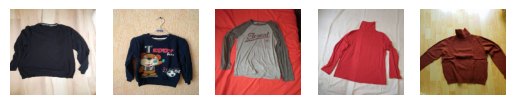

Undershirt


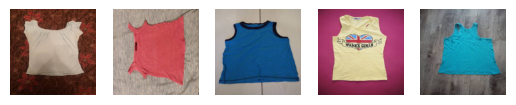

Hat


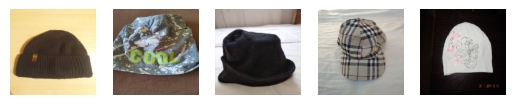

Polo


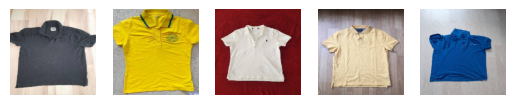

Blouse


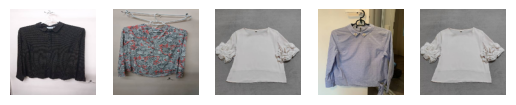

Hoodie


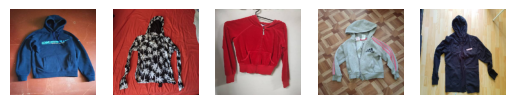

Blazer


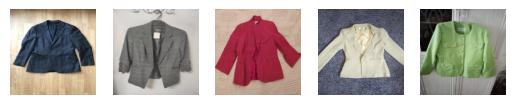

In [20]:
for label in labels_lst:
    print(label)
    display_sample_images('training', label)

In [21]:
# Check the number of images in each directory
def check_no_images(label):
    print(f'{label} Total Images:', labels[labels.label == label].shape[0])
    print(f'{label} Training Images:', len(os.listdir(os.path.join(destination_dir, 'training', label))))
    print(f'{label} Validation Images:', len(os.listdir(os.path.join(destination_dir, 'validation', label))))
    print(f'{label} Testing Images:', len(os.listdir(os.path.join(destination_dir, 'testing', label))))

In [22]:
check_no_images('T-Shirt')

T-Shirt Total Images: 1011
T-Shirt Training Images: 819
T-Shirt Validation Images: 91
T-Shirt Testing Images: 101


In [23]:
check_no_images('Shoes')

Shoes Total Images: 431
Shoes Training Images: 349
Shoes Validation Images: 39
Shoes Testing Images: 43


# Data Preparation

In [24]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dir = os.path.join(destination_dir, 'training')
valid_dir = os.path.join(destination_dir, 'validation')
test_dir = os.path.join(destination_dir, 'testing')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical')

Found 4365 images belonging to 19 classes.
Found 486 images belonging to 19 classes.
Found 540 images belonging to 19 classes.


In [25]:
total_no_images = train_generator.n + valid_generator.n + test_generator.n
print('Training Images:', round(train_generator.n / total_no_images *100, 2), '%')
print('Validation Images:', round(valid_generator.n / total_no_images *100, 2), '%')
print('Testing Images:', round(test_generator.n / total_no_images *100, 2), '%')

Training Images: 80.97 %
Validation Images: 9.02 %
Testing Images: 10.02 %


In [26]:
# Check the total number of images 
assert len(labels) == total_no_images, 'Total number of images does not match'

# Modelling

## Base Model

In [27]:
# create model
model = Sequential([    Conv2D(32, (3,3), activation='relu', input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3)),
                        MaxPooling2D(2, 2),
                        Conv2D(64, (3,3), activation='relu'),
                        MaxPooling2D(2,2),
                        Conv2D(128, (3,3), activation='relu'),
                        MaxPooling2D(2,2),

                        Flatten(),
                        Dense(128, activation='relu'),
                        Dense(19, activation='softmax')  ])

# Compile model 
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,411 (42.62 MB)

 Trainable params: 11,171,411 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(train_generator, epochs=5, verbose=1,validation_data=valid_generator)

Epoch 1/5


I0000 00:00:1728386986.410972      89 service.cc:145] XLA service 0x7c6a4c0061d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728386986.411065      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/137 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.0903 - loss: 5.4498 

I0000 00:00:1728386990.653392      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


137/137 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.1712 - loss: 3.0410 - val_accuracy: 0.3333 - val_loss: 2.2799
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.4048 - loss: 2.1142 - val_accuracy: 0.4444 - val_loss: 1.9241
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.5368 - loss: 1.6792 - val_accuracy: 0.4938 - val_loss: 1.7313
Epoch 4/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.6054 - loss: 1.3612 - val_accuracy: 0.5412 - val_loss: 1.7158
Epoch 5/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7008 - loss: 1.0358 - val_accuracy: 0.5226 - val_loss: 1.7748


<Axes: >

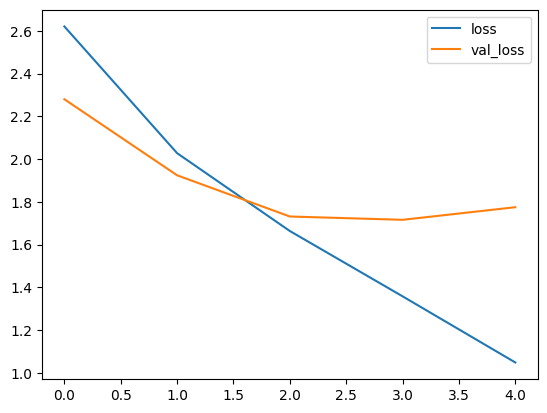

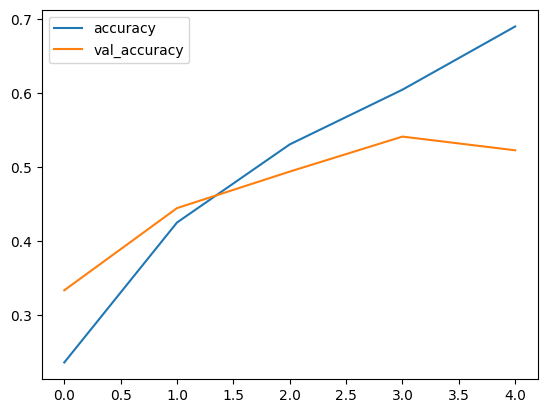

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

# 

# Xception Model

In [30]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False
inputs = Input(shape= (IMAGE_SIZE, IMAGE_SIZE, 3))
base = base_model(inputs, training=False)

# Flatten the output layer to 1 dimension
x = Flatten()(base)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)        

# Add a final sigmoid layer for classification
x = Dense(19, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(inputs, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 19)             │        19,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,642,427 (471.66 MB)

 Trainable params: 102,780,947 (392.08 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=5, verbose=1,validation_data=valid_generator)

Epoch 1/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.4049 - loss: 14.4401 - val_accuracy: 0.6934 - val_loss: 1.3577
Epoch 2/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8343 - loss: 0.5139 - val_accuracy: 0.7016 - val_loss: 1.2439
Epoch 3/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.9016 - loss: 0.2845 - val_accuracy: 0.7181 - val_loss: 1.2326
Epoch 4/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9614 - loss: 0.1270 - val_accuracy: 0.7058 - val_loss: 1.2134
Epoch 5/5
137/137 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.9826 - loss: 0.0596 - val_accuracy: 0.7140 - val_loss: 1.1738


<Axes: >

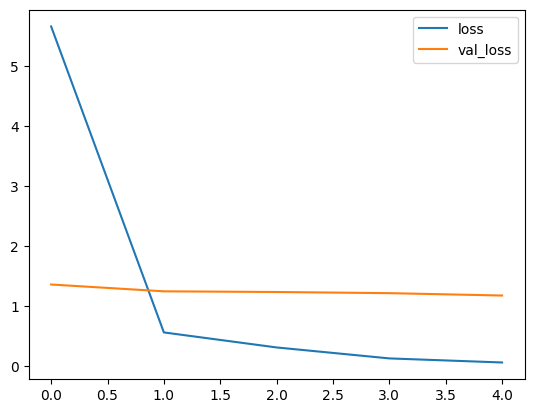

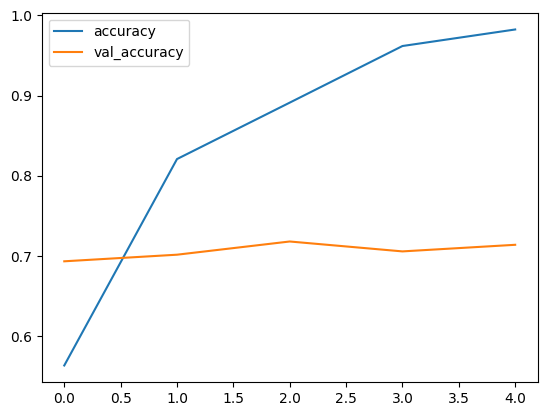

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()

# Data Augmentation & Regularization

In [33]:
aug_train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

train_generator = aug_train_datagen.flow_from_directory(
    train_dir,
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='categorical')

Found 4365 images belonging to 19 classes.


In [34]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape= (IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_model.trainable = False
inputs = Input(shape= (IMAGE_SIZE, IMAGE_SIZE, 3))
base = base_model(inputs, training=False)

# Flatten the output layer to 1 dimension
x = Flatten()(base)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2')(x)        

# Add a dropout rate 
x = Dropout(0.2)(x)

# Add a final sigmoid layer for classification
x = Dense(19, activation='sigmoid')(x)           

# Append the dense network to the base model
aug_model = Model(inputs, x) 

# Print the model summary. See your dense network connected at the end.
aug_model.summary() 

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │        19,475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,642,427 (471.66 MB)

 Trainable params: 102,780,947 (392.08 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [35]:
my_callbacks = [ EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001),
                 ModelCheckpoint('/kaggle/working/model.keras', monitor='val_loss', save_best_only=True)]

optimizer = Adamax(learning_rate=0.001)
#optimizer = Adam(learning_rate=0.001)
#optimizer = RMSprop(learning_rate=0.001)

aug_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
aug_history = aug_model.fit(train_generator, epochs=20, verbose=1,validation_data=valid_generator, callbacks=my_callbacks)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 77s 457ms/step - accuracy: 0.2797 - loss: 30.1523 - val_accuracy: 0.6255 - val_loss: 8.6427
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 57s 401ms/step - accuracy: 0.5268 - loss: 7.8731 - val_accuracy: 0.6358 - val_loss: 5.2439
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 389ms/step - accuracy: 0.5437 - loss: 5.0625 - val_accuracy: 0.6564 - val_loss: 3.6229
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 57s 397ms/step - accuracy: 0.5606 - loss: 3.7049 - val_accuracy: 0.6626 - val_loss: 2.8441
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 82s 397ms/step - accuracy: 0.5701 - loss: 2.9612 - val_accuracy: 0.6399 - val_loss: 2.4876
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 57s 395ms/step - accuracy: 0.5604 - loss: 2.5727 - val_accuracy: 0.6687 - val_loss: 2.0718
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 394ms/step - accuracy: 0.5536 - loss: 2.3633 - val_accuracy: 0.6584 - val_loss: 1.9368
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 56s 391ms/step - accuracy: 0.5644 - loss: 

<Axes: >

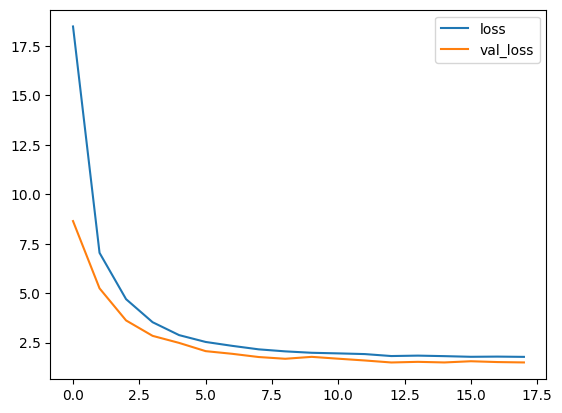

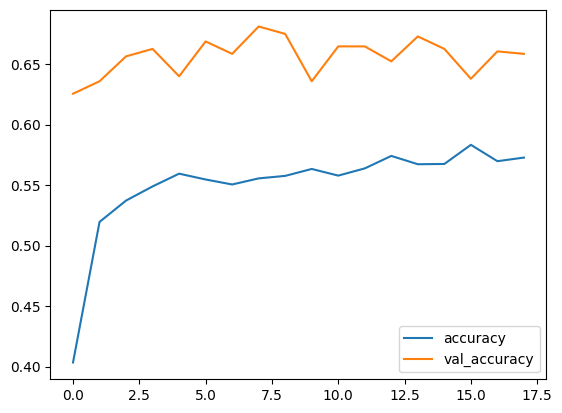

In [36]:
aug_history_df = pd.DataFrame(aug_history.history)
aug_history_df.loc[:,['loss','val_loss']].plot()
aug_history_df.loc[:,['accuracy','val_accuracy']].plot()

In [37]:
train_acc = model.evaluate(train_generator)[1]
valid_acc = model.evaluate(valid_generator)[1]
print("Transfer Learning Model Accuracy on Training Data: ", train_acc)
print("Transfer Learning Model Accuracy on Validation Data: ", valid_acc)

137/137 ━━━━━━━━━━━━━━━━━━━━ 50s 363ms/step - accuracy: 0.4740 - loss: 2.2137
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7314 - loss: 1.1547
Transfer Learning Model Accuracy on Training Data:  0.47812142968177795
Transfer Learning Model Accuracy on Validation Data:  0.7139917612075806
